File loaded successfully as Excel!


/tmp/ipython-input-2660098055.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Month_Year'] = df_clean['Order_Date_Cleaned'].dt.to_period('M')
/tmp/ipython-input-2660098055.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_sales.index, y=category_sales.values, ax=axes[0, 0], palette='viridis')



 DASHBOARD KPIs
 Total Sales:    $14,806,550.12
 Total Profit:   $1,508,090.71
 Profit Margin:  10.19%


/tmp/ipython-input-2660098055.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_products.index, x=top_products.values, ax=axes[1, 0], palette='magma')


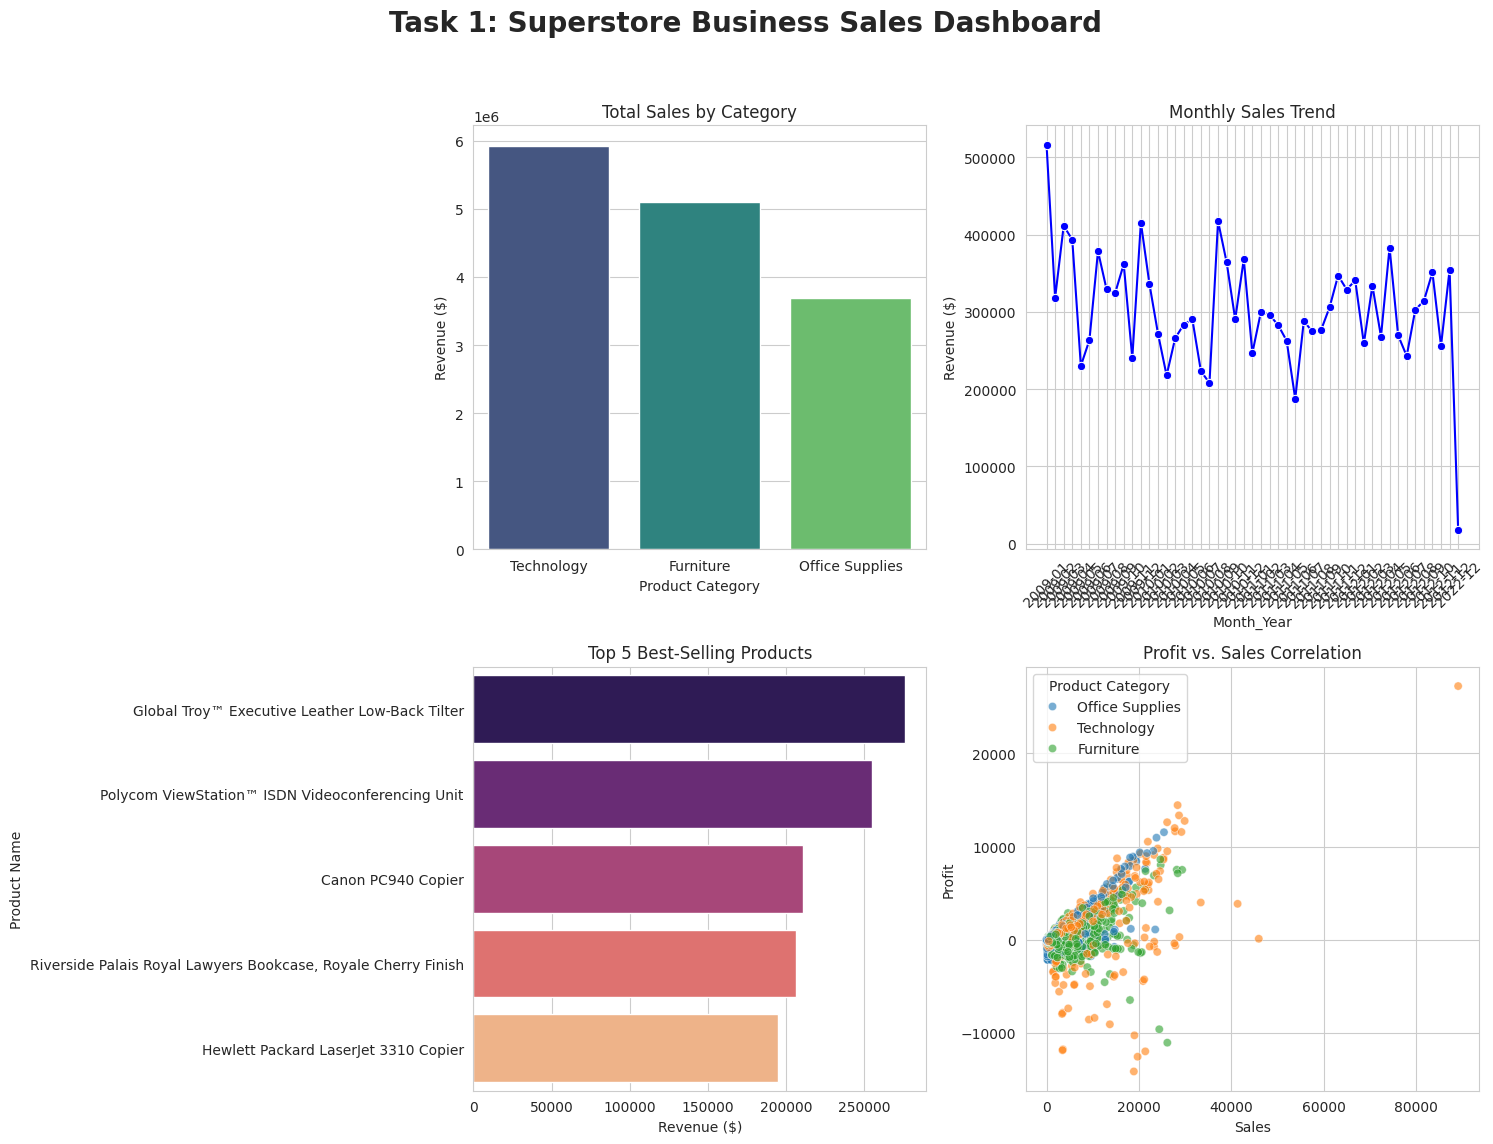

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# --- PART 1: LOAD & CLEAN DATA ---
filename = '/content/SampleSuperstore .xls'

# Load the dataset
try:
    # First, try reading as an Excel file given the .xls extension
    df = pd.read_excel(filename)
    print("File loaded successfully as Excel!")
except FileNotFoundError:
    print(" Error: File not found. Please upload 'SampleSuperstore .xls' first.")
    exit()
except Exception as e_excel:
    print(f"Error reading as Excel: {e_excel}")
    print("Attempting to read as CSV (in case it's a misnamed CSV)...")
    try:
        # If Excel read fails, try reading as CSV with 'latin1' encoding
        df = pd.read_csv(filename, encoding='latin1')
        print("File loaded successfully as CSV!")
    except (UnicodeDecodeError, pd.errors.ParserError) as e_csv:
        print(f"Error reading as CSV: {e_csv}")
        print("Error: Could not read the file as either Excel or CSV. Please ensure the file is valid and correctly formatted.")
        exit()
    except Exception as e_general_csv:
        print(f"An unexpected error occurred while reading as CSV: {e_general_csv}")
        exit()

# FUNCTION: Fix Excel Serial Dates
def parse_excel_date(serial):
    try:
        # Check if it's a float/int (Excel serial date)
        serial_float = float(serial)
        # Excel base date is Dec 30, 1899
        return datetime.datetime(1899, 12, 30) + datetime.timedelta(days=serial_float)
    except (ValueError, TypeError):
        # If it's not a number, try standard date parsing or return NaT (Not a Time)
        return pd.to_datetime(serial, errors='coerce')

# Apply the cleaning function to Order Date
df['Order_Date_Cleaned'] = df['Order Date'].apply(parse_excel_date)

# Convert Sales and Profit to numeric (forcing errors to NaN)
df['Sales'] = pd.to_numeric(df['Sales'], errors='coerce')
df['Profit'] = pd.to_numeric(df['Profit'], errors='coerce')

# Drop rows with missing Dates or Sales (Clean the garbage data)
df_clean = df.dropna(subset=['Order_Date_Cleaned', 'Sales', 'Profit'])

# Extract Month-Year for Trend Analysis
df_clean['Month_Year'] = df_clean['Order_Date_Cleaned'].dt.to_period('M')

# --- PART 2: KPI CALCULATION ---
total_sales = df_clean['Sales'].sum()
total_profit = df_clean['Profit'].sum()
profit_margin = (total_profit / total_sales) * 100

print("\n DASHBOARD KPIs")
print(f" Total Sales:    ${total_sales:,.2f}")
print(f" Total Profit:   ${total_profit:,.2f}")
print(f" Profit Margin:  {profit_margin:.2f}%")

# --- PART 3: VISUALIZATIONS ---
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Task 1: Superstore Business Sales Dashboard', fontsize=20, weight='bold')

# Chart 1: Sales by Category
category_sales = df_clean.groupby('Product Category')['Sales'].sum().sort_values(ascending=False)
sns.barplot(x=category_sales.index, y=category_sales.values, ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('Total Sales by Category')
axes[0, 0].set_ylabel('Revenue ($)')

# Chart 2: Monthly Sales Trend
monthly_trend = df_clean.groupby('Month_Year')['Sales'].sum()
monthly_trend.index = monthly_trend.index.astype(str) # Convert for plotting
sns.lineplot(x=monthly_trend.index, y=monthly_trend.values, ax=axes[0, 1], marker='o', color='blue')
axes[0, 1].set_title('Monthly Sales Trend')
axes[0, 1].set_ylabel('Revenue ($)')
axes[0, 1].tick_params(axis='x', rotation=45) # Rotate labels to prevent overlap

# Chart 3: Top 5 Products
top_products = df_clean.groupby('Product Name')['Sales'].sum().sort_values(ascending=False).head(5)
sns.barplot(y=top_products.index, x=top_products.values, ax=axes[1, 0], palette='magma')
axes[1, 0].set_title('Top 5 Best-Selling Products')
axes[1, 0].set_xlabel('Revenue ($)')

# Chart 4: Profit vs. Sales Correlation
sns.scatterplot(data=df_clean, x='Sales', y='Profit', hue='Product Category', ax=axes[1, 1], alpha=0.6)
axes[1, 1].set_title('Profit vs. Sales Correlation')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()